# Keras Notebook 
  

In [1]:
import sys
import os
import pandas as pd
from sklearn.impute import SimpleImputer



In [2]:
#import tensorflow as tf

#print("TensorFlow version:", tf.__version__)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import KNNImputer

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Safe Keras
from aisdc.safemodel.classifiers import SafeKerasModel

# set tensorflow messages to warning level
tf.get_logger().setLevel("WARNING")

## A Quick Start Guide to implementing Safer Keras Models
### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset


**NOTE**


**NOTE**: batch_size 25 so DP optimizer would run with same hyperparams

**NOTE**: Next cell determines which dataset is used

In [32]:
train_data = pd.read_csv("C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv")

In [33]:
#datatrain.head(2)

In [34]:
train_data = train_data
#data = data.set_index('participant_id')
#data[~data.index.duplicated(keep='first')]
train_data = train_data.drop(columns=['participant_id', 'Measure:volume'])

train_data = train_data[train_data['diagnosis'] != 'MCI']

diagnosis_mapping = {'CN': 0, 'AD': 1, 0.666667: 0}
train_data['diagnosis'] = train_data['diagnosis'].map(diagnosis_mapping)

train_data = train_data[(train_data['diagnosis'] == 0) | (train_data['diagnosis'] == 1)]

In [35]:
target = train_data['diagnosis']

In [36]:
train_data

,Unnamed: 0,session_id,diagnosis,mmse,cdr,cdr_sb,age,examination_date,earliest_time,Left-Lateral-Ventricle,...,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,eTIV
6,6,ses-M06,1.0,21.0,0.5,3.0,60.795551,2007-03-29,2006-09-29,28066.7,...,13346.0,18892.0,9713.0,9722.0,7670.0,892.0,2084.0,1193.0,7439.0,1.871867e+06
7,7,ses-M12,1.0,27.0,0.5,2.5,61.288364,2007-09-25,2006-09-29,28795.7,...,13177.0,18986.0,10157.0,9451.0,8172.0,1052.0,1956.0,1343.0,7475.0,1.874112e+06
8,8,ses-M18,1.0,24.0,1.0,4.5,61.767488,2008-03-18,2006-09-29,31601.5,...,13137.0,18183.0,9465.0,9635.0,7903.0,915.0,1959.0,1166.0,7526.0,1.858567e+06
9,9,ses-M24,1.0,22.0,1.0,6.0,62.304107,2008-09-30,2006-09-29,33467.7,...,12404.0,18009.0,9408.0,9154.0,7673.0,1064.0,1918.0,1321.0,6198.0,1.875003e+06
12,12,ses-M18,1.0,25.0,0.5,2.5,78.178439,2008-08-20,2007-02-27,39624.2,...,13432.0,18338.0,9474.0,11103.0,9137.0,984.0,2702.0,834.0,7797.0,1.745240e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,ses-M12,1.0,5.0,3.0,15.0,78.248597,2007-02-13,2006-01-26,34943.5,...,9322.0,13443.0,8216.0,6891.0,6819.0,835.0,1850.0,706.0,4294.0,1.445415e+06
1929,1929,ses-M24,1.0,4.0,3.0,17.0,79.204107,2008-01-28,2006-01-26,39970.8,...,8694.0,12480.0,7723.0,6441.0,5696.0,1067.0,1690.0,503.0,4224.0,1.427609e+06
1936,1936,ses-M00,1.0,24.0,1.0,4.5,55.100000,2007-05-15,2007-05-15,22438.1,...,11314.0,18318.0,10818.0,9060.0,7557.0,1118.0,1868.0,571.0,5726.0,1.532619e+06
1937,1937,ses-M06,1.0,22.0,1.0,4.5,55.598289,2007-11-13,2007-05-15,25533.9,...,10987.0,18519.0,10615.0,9081.0,7498.0,1105.0,2099.0,713.0,6162.0,1.528047e+06


In [37]:
features = train_data.drop('diagnosis', axis=1)

In [38]:
features.shape[1]

145

In [39]:
list(features)

['Unnamed: 0',
 'session_id',
 'mmse',
 'cdr',
 'cdr_sb',
 'age',
 'examination_date',
 'earliest_time',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 '3rd-Ventricle',
 '4th-Ventricle',
 'Brain-Stem',
 'Left-Hippocampus',
 'Left-Amygdala',
 'CSF',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 '5th-Ventricle',
 'WM-hypointensities',
 'Left-WM-hypointensities',
 'Right-WM-hypointensities',
 'non-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'Right-non-WM-hypointensities',
 'Optic-Chiasm',

### Pre-Process Data

In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate columns by data type
object_cols = features.select_dtypes(include=['object']).columns
float_cols = features.select_dtypes(include=['float64']).columns

# Create transformers
object_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('obj', object_transformer, object_cols),
        ('float', float_transformer, float_cols)
    ])

# Apply transformations
transformed_features = preprocessor.fit_transform(features)

In [12]:
# Convert np array
#X_1_dense = transformed_features.toarray()


In [42]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [43]:
oversample = SMOTE()
X,y = oversample.fit_resample(transformed_features, target)
y = pd.DataFrame(y)

In [44]:

# Use LabelEncoder to convert categorical labels to numerical labels
#label_encoder = LabelEncoder()
#target = label_encoder.fit_transform(target)

# Convert y to categorical encoding
y_one = to_categorical(target)
#yval = to_categorical(yval)




In [45]:
#Split data
X_1, Xval, y_1, yval = train_test_split(
    transformed_features, y_one, test_size=0.3, shuffle=True, random_state=12345
  )

In [17]:
print("Input shape:", X_1.shape)

Input shape: (765, 139)


In [18]:
print("Input shape:", Xval.shape)

Input shape: (329, 139)


In [19]:
print("Input shape:", y_1.shape)

Input shape: (765, 2)


In [20]:
print("Input shape:", yval.shape)

Input shape: (329, 2)


## Define the target model architecture
### Set loss and compile
*Again, we use a rather big model (for the classification task) to favour overfitting.*

In [46]:

# Set seed for reproducibility
tf.random.set_seed(12345)

# Specify a seed for the GlorotUniform initializer
initializer = tf.keras.initializers.GlorotUniform(seed=42)

# n_classes is the number of classes in classification problem
n_classes = 2

#  X_1[0].shape is the shape of input data
#input_data = Input(shape=X_1[0].shape)
input_data = Input(shape=X_1.shape[1:])
x = Dense(128, activation="relu", kernel_initializer=initializer)(input_data)
x = Dense(128, activation="relu", kernel_initializer=initializer)(x)
x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
output = Dense(n_classes, activation="softmax", kernel_initializer=initializer)(x)

# Create the model
model = Model(inputs=input_data, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3202)]            0         
                                                                 
 dense (Dense)               (None, 128)               409984    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 434,882
Trainable params: 434,882
Non-trainable params: 0
_________________________________________________________________


### Fit the model

Epoch 1/40
31/31 [==============================] - 1s 12ms/step - loss: 4948.5771 - accuracy: 0.4732 - val_loss: 1843.3585 - val_accuracy: 0.4742
Epoch 2/40
31/31 [==============================] - 0s 6ms/step - loss: 1813.8876 - accuracy: 0.5503 - val_loss: 3026.3606 - val_accuracy: 0.4742
Epoch 3/40
31/31 [==============================] - 0s 7ms/step - loss: 1133.0387 - accuracy: 0.5686 - val_loss: 767.3672 - val_accuracy: 0.4833
Epoch 4/40
31/31 [==============================] - 0s 6ms/step - loss: 944.2821 - accuracy: 0.6013 - val_loss: 519.8740 - val_accuracy: 0.5380
Epoch 5/40
31/31 [==============================] - 0s 7ms/step - loss: 409.3156 - accuracy: 0.6588 - val_loss: 346.8732 - val_accuracy: 0.6869
Epoch 6/40
31/31 [==============================] - 0s 7ms/step - loss: 268.7613 - accuracy: 0.6680 - val_loss: 149.3814 - val_accuracy: 0.7629
Epoch 7/40
31/31 [==============================] - 0s 7ms/step - loss: 297.7913 - accuracy: 0.7020 - val_loss: 173.8156 - val_acc

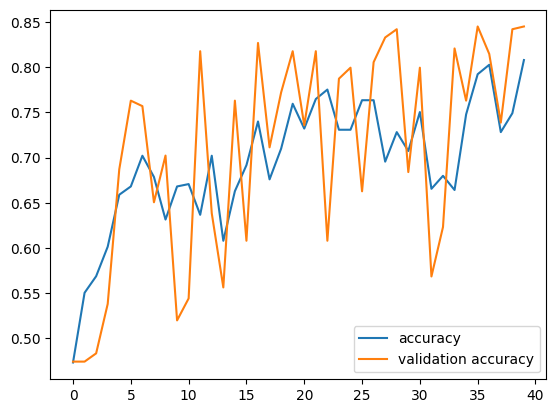

24/24 [==============================] - 0s 2ms/step
model training  report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83       394
           1       0.80      0.89      0.84       371

    accuracy                           0.84       765
   macro avg       0.84      0.84      0.84       765
weighted avg       0.84      0.84      0.84       765



In [47]:

epochs = 40
batch_size = 25


r_DP = model.fit(
    X_1,
    y_1,
    validation_data=(Xval, yval),
    epochs=epochs,
    batch_size=batch_size,
)
if r_DP == None:
    print("You have chosen to exit. Reset relevant parameter values then re-run fit().")
else:
    plt.plot(r_DP.history["accuracy"], label="accuracy")
    plt.plot(r_DP.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.show()
    #ypred = safeModel.predict(X)
    y_pred = model.predict(X_1)
    ylabels = np.argmax(y_1, axis=1)
    ypredlabels = np.argmax(y_pred, axis=1)
    print(f"model training  report:\n {classification_report(ylabels,ypredlabels,zero_division=1)}")

In [55]:
skmodel = model

In [52]:
from art.attacks.inference.reconstruction import DatabaseReconstruction
# from art.estimators.estimator import DecisionTreeMixin
from art.estimators.estimator import DecisionTreeMixin
# from art.estimators.classification.classifier import ClassifierDecisionTree
from art.estimators.scikitlearn import ScikitlearnEstimator
from art.estimators.classification.scikitlearn import SklearnClassifier

In [56]:
art_classifier = SklearnClassifier(model=skmodel)
dbrecon = DatabaseReconstruction(art_classifier)

TypeError: Model is not an sklearn model. Received '<class 'keras.engine.functional.Functional'>'

### **Membership Inference Attack**

In [840]:
x_train = X_1
y_train = y_1

x_test = Xval
y_test = yval

In [40]:
tf.compat.v1.disable_eager_execution()

In [41]:
from art.estimators.classification import KerasClassifier

INFO:art.config:set ART_DATA_PATH to C:\Users\kafayat.adeoye\.art\data


In [43]:
# Construct the ART classifier
# Wrap the model with ART's KerasClassifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))

INFO:art.estimators.classification.keras:Inferred 3 hidden layers on Keras classifier.


In [44]:
# to determine whether a specific data point was part of the training set or not.
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

attack = MembershipInferenceBlackBoxRuleBased(classifier)

In [45]:
# Perform membership inference attack
# Attack model to output probabilities
attack_train_prob = attack.infer(x_train, y_train, probabilities=True)

C:\Users\kafayat.adeoye\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [46]:
# Create synthetic labels for the membership inference attack 
# Converts the probabilities obtained from the attack model (attack_train_prob) into binary labels. If the probability is greater than 0.5, 
# it assigns a label of 1; otherwise, it assigns a label of 0.
attack_train_labels = (attack_train_prob > 0.5).astype(int)

In [47]:
# infer attacked feature
inferred_train = attack.infer(x_train, y_train)
inferred_test = attack.infer(x_test, y_test)

In [48]:
# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 0.4850
Non Members Accuracy 0.5258
Attack Accuracy 0.4973


A Membership Inference Attack is a type of privacy attack aimed at determining whether a specific data sample was part of the training dataset used to train a machine learning model. The attacker, tries to infer whether a particular data point was included in the training data based on the model's predictions. 
Possible Defenses: To mitigate membership inference attacks, model developers can explore techniques such as differential privacy, data augmentation, and adversarial training. 
precision represents the accuracy of the attack in correctly identifying samples that were part of the training set. ------% of the instances predicted as "members" by the attack were true members
recall ability of the attack to correctly identify members out of all actual members. -----% of the instances that were actually part of the training set.
F1-score indicates the overall effectiveness of the attack.
ROC AUC a value of 0.5 suggests that the attack is not performing better than random guessing, while values above 0.5 indicate some level of discrimination. suggesting that the attacker cannot reliably distinguishing between training and test samples, higher value, it may suggest a potential vulnerability to membership inference attacks.
low precision and recall values indicate that the attack is not very accurate in identifying membership in the training set.
high average precision may indicate that the attack has a better balance between precision and recall
the membership inference attack, based on the provided metrics, is not highly effective in accurately identifying training set members.

### **Attribute Inference**

In [836]:
from art.attacks.inference.attribute_inference import AttributeInferenceBlackBox

In [907]:
attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_train) * attack_train_ratio)
attack_x_train = x_train[:attack_train_size]
attack_y_train = y_train[:attack_train_size]
attack_x_test = x_train[attack_train_size:]
attack_y_test = y_train[attack_train_size:]

In [908]:
attack_x_test.shape

(383, 139)

In [909]:
#list(feature_names)

**Train Attack Model**

In [910]:
attack_feature_name = 'mmse'  # Use the feature name
attack_feature_index = list(features.columns).index(attack_feature_name)
attack_feature_index

0

In [911]:
attack_x_test

array([[1.90000000e+01, 1.00000000e+00, 6.50000000e+00, ...,
        6.70000000e+02, 5.92700000e+03, 1.60639447e+06],
       [5.00000000e+00, 3.00000000e+00, 1.50000000e+01, ...,
        7.06000000e+02, 4.29400000e+03, 1.44541533e+06],
       [3.00000000e+01, 0.00000000e+00, 5.00000000e-01, ...,
        5.99000000e+02, 7.61500000e+03, 1.43933046e+06],
       ...,
       [3.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        5.64000000e+02, 6.13200000e+03, 1.67181735e+06],
       [2.80000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        8.10000000e+02, 8.79800000e+03, 1.58387834e+06],
       [2.80000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        5.72000000e+02, 5.45700000e+03, 1.11543162e+06]])

In [912]:
# get original model's predictions
#attack_x_test_predictions = classifier.predict(attack_x_test)

attack_x_test_prediction = np.array([np.argmax(arr) for arr in classifier.predict(attack_x_test)]).reshape(-1,1)

In [913]:
# only attacked feature
attack_x_test_feature = attack_x_test[:, attack_feature_index].copy().reshape(-1,1)


In [914]:
# training data without attacked feature
attack_x_test = np.delete(attack_x_test, attack_feature_index, 1)


In [932]:
bb_attack = AttributeInferenceBlackBox(classifier, attack_feature=attack_feature_index)

# train attack model
bb_attack.fit(attack_x_train)

**Infer sensitive feature and check accuracy**

In [933]:
values = [5.0, 19.0, 30.0, 26.0, 23.0]
# Perform attribute inference
inferred_train_bb = bb_attack.infer(attack_x_test, pred=attack_x_test_predictions, values=values)


In [934]:
# check accuracy
train_acc = np.sum(inferred_train_bb == np.around(attack_x_test_feature, decimals=5).reshape(1,-1)) / len(inferred_train_bb)
print(train_acc)

0.25326370757180156


In [939]:
#attack_x_test_feature

In [940]:
#attack_x_test

In [937]:
from art.attacks.inference.attribute_inference import AttributeInferenceBaseline

baseline_attack = AttributeInferenceBaseline(attack_feature=attack_feature_index)
# train attack model
baseline_attack.fit(attack_x_train)


In [938]:
# infer values
inferred_train_baseline = baseline_attack.infer(attack_x_test, values=values)
# check accuracy
baseline_train_acc = np.sum(inferred_train_baseline == np.around(attack_x_test_feature, decimals=5).reshape(1,-1)) / len(inferred_train_baseline)
print(baseline_train_acc)

0.25326370757180156


In [950]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

mem_attack = MembershipInferenceBlackBox(classifier)

mem_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size], x_test[:attack_test_size], y_test[:attack_test_size])

In [951]:
from art.attacks.inference.attribute_inference import AttributeInferenceMembership

attack = AttributeInferenceMembership(classifier, mem_attack, attack_feature=attack_feature_index)



In [952]:
# infer values
inferred_train = attack.infer(attack_x_test, attack_y_test, values=values)

# check accuracy     v         
train_acc = np.sum(inferred_train == np.around(attack_x_test_feature, decimals=8).reshape(1,-1)) / len(inferred_train)
print(train_acc)

0.0026109660574412533


### **Evasion Attacks**

In [136]:
from art.attacks.evasion import FastGradientMethod

# Wrap the model with ART's KerasClassifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Generate adversarial examples using Fast Gradient Method (FGM)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack_fgsm.generate(x_test)

# Evaluate the model on adversarial examples
accuracy_adv = np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial examples: {accuracy_adv}')


INFO:art.estimators.classification.keras:Inferred 3 hidden layers on Keras classifier.
INFO:art.attacks.evasion.fast_gradient:Using model predictions as correct labels for FGM.
INFO:art.attacks.evasion.fast_gradient:Success rate of FGM attack: 0.00%


Accuracy on adversarial examples: 0.47416413373860183


Adversarial samples, also known as adversarial examples, refer to specially crafted inputs that are intentionally designed to mislead machine learning models. These inputs are created by applying small and often imperceptible perturbations to legitimate inputs with the goal of causing the model to make incorrect predictions.

Inferred Hidden Layers: The ART library inferred that the Keras classifier has 3 hidden layers.

Success Rate of FGM Attack: The success rate of the FGM attack is reported as 0.00%. This means that, despite the attack attempts, none of the generated adversarial examples successfully caused misclassification.

Accuracy on Adversarial Examples: The accuracy on adversarial examples is reported as 0.47. This accuracy is likely based on the model's predictions on the adversarial examples, and the value suggests that the model performed poorly on these perturbed samples.

Carlini and Wagner L2 attack, which is a type of adversarial attack aimed at crafting perturbations on input data to mislead a machine learning model. 

In [137]:
from art.attacks.evasion import CarliniL2Method

# Create the Carlini and Wagner L2 attack
attack_carlini = CarliniL2Method(classifier, targeted=False, confidence=0.0, learning_rate=0.01, max_iter=100, binary_search_steps=10, initial_const=0.01)

# Generate adversarial examples
x_test_adv_carlini = attack_carlini.generate(x_test)

# Evaluate the success rate of the Carlini and Wagner L2 attack
success_rate_carlini = np.sum(np.argmax(classifier.predict(x_test_adv_carlini), axis=1) != np.argmax(y_test, axis=1)) / len(y_test)
print(f"Success rate of Carlini and Wagner L2 attack: {success_rate_carlini * 100:.2f}%")

# Evaluate accuracy on adversarial examples
accuracy_adv_carlini = np.sum(np.argmax(classifier.predict(x_test_adv_carlini), axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on Carlini and Wagner L2 adversarial examples: {accuracy_adv_carlini * 100:.2f}%")


C&W L_2:   0%|          | 0/329 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Success rate of Carlini and Wagner L2 attack: 52.58%
Accuracy on Carlini and Wagner L2 adversarial examples: 47.42%


Carlini and Wagner L2 attack in successfully crafting adversarial examples. A success rate of 52.58% suggests that a significant portion of the attack attempts were successful.
accuracy of 47.42% implies that the model's performance decreases when evaluated on these adversarial examples compared to its accuracy on clean (non-adversarial) examples.
model's accuracy on these generated adversarial examples dropped to 47.42%, indicating the effectiveness of the attack in causing misclassifications
Essential to prioritize privacy-preserving practices to handle sensitive data

### **Additional Black-box attack membership inference attacks**

In [956]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

bbb_attack = MembershipInferenceBlackBox(classifier)

# train attack model
bbb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
              x_test[:attack_test_size], y_test[:attack_test_size])

**Infer membership and check accuracy**

In [957]:
# get inferred values
inferred_train_bb = bbb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bbb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 1.0000
Non Members Accuracy 0.0000
Attack Accuracy 0.6989


In [962]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall


In [963]:
# black-box
print(calc_precision_recall(np.concatenate((inferred_train_bb, inferred_test_bb)), 
                            np.concatenate((np.ones(len(inferred_train_bb)), np.zeros(len(inferred_test_bb))))))

(0.698905109489051, 1.0)


**Rule-based attack**

In [964]:
mlp_attack = MembershipInferenceBlackBoxRuleBased(classifier)

# infer 
mlp_inferred_train = mlp_attack.infer(x_train.astype(np.float32), y_train)
mlp_inferred_test = mlp_attack.infer(x_test.astype(np.float32), y_test)

# check accuracy
mlp_train_acc = np.sum(mlp_inferred_train) / len(mlp_inferred_train)
mlp_test_acc = 1 - (np.sum(mlp_inferred_test) / len(mlp_inferred_test))
mlp_acc = (mlp_train_acc * len(mlp_inferred_train) + mlp_test_acc * len(mlp_inferred_test)) / (len(mlp_inferred_train) + len(mlp_inferred_test))
print(mlp_train_acc)
print(mlp_test_acc)
print(mlp_acc)

print(calc_precision_recall(np.concatenate((mlp_inferred_train, mlp_inferred_test)), 
                            np.concatenate((np.ones(len(mlp_inferred_train)), np.zeros(len(mlp_inferred_test))))))

0.4849673202614379
0.5258358662613982
0.49725776965265084
(0.7039848197343453, 0.4849673202614379)


In [965]:
mlp_attack_bb = MembershipInferenceBlackBox(classifier, attack_model_type='rf')

# train attack model
mlp_attack_bb.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size],
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size])

# infer 
mlp_inferred_train_bb = mlp_attack_bb.infer(x_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
mlp_inferred_test_bb = mlp_attack_bb.infer(x_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

# check accuracy
mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
print(f"Attack Accuracy {mlp_acc_bb:.4f}")

print(calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)), 
                            np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb))))))

Members Accuracy: 1.0000
Non Members Accuracy 0.0000
Attack Accuracy 0.6989
(0.698905109489051, 1.0)
